Problem 1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
torch.manual_seed(99)
np.random.seed(99)
device = torch.device("cpu")


In [ ]:
file_path = "/content/hw1data.dat"
data = np.loadtxt(file_path, delimiter='\t')

X = data[:, :2]
y = data[:, 2]

y = (y + 1) / 2

print(X)
print(y)

[[0.73662472 0.50544176]
 [0.71066494 0.56503663]
 [0.10533493 0.06889585]
 ...
 [0.15670748 0.93967311]
 [0.73948357 0.71284126]
 [0.6317367  0.93890702]]
[0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1.
 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device).view(-1, 1)




In [ ]:


class BinaryClassifier(nn.Module):
    def __init__(self, activation_function):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(2, 5)
        self.fc2 = nn.Linear(5, 1)
        self.activation = activation_function

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

def train_model(activation_function, optimizer_name, optimizer_params={}, patience=10):
    activation_functions = {'relu': nn.ReLU(), 'tanh': nn.Tanh(), 'sigmoid': nn.Sigmoid()}
    optimizers = {
        'sgd': lambda params: optim.SGD(params, **optimizer_params),
        'rmsprop': lambda params: optim.RMSprop(params, **optimizer_params),
        'adam': lambda params: optim.Adam(params, **optimizer_params)
    }

    model = BinaryClassifier(activation_functions[activation_function]).to(device)
    optimizer = optimizers[optimizer_name](model.parameters())
    criterion = nn.BCELoss()

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

    losses = []
    best_loss = float('inf')
    patience_counter = 0
    epoch = 0  # Remove explicit limit on epochs

    while True:  # Infinite loop until convergence
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        scheduler.step(loss)

        #if epoch % 100 == 0:
            #print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

        # Early stopping condition
        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0  # Reset counter when loss improves
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        epoch += 1  # Keep increasing epoch count

    # Evaluate model
    with torch.no_grad():
        y_pred = model(X_train_tensor)
        y_pred_class = (y_pred >= 0.5).float()
        train_accuracy = (y_pred_class.eq(y_train_tensor).sum().item()) / y_train_tensor.shape[0]

        y_pred = model(X_test_tensor)
        y_pred_class = (y_pred >= 0.5).float()
        test_accuracy = (y_pred_class.eq(y_test_tensor).sum().item()) / y_test_tensor.shape[0]

    results = {
        'epochs': epoch,  # Record the final epoch count
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'prediction': predict(model, torch.tensor([0.8, 0.2], device=device)),
        'model': model,
        'losses': losses
    }

    print(f"Final Training Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    return test_accuracy, losses, model, results


In [ ]:
class BinaryClassifier(nn.Module):
    def __init__(self, activation_function):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(2, 5) #2 input to 5 dense matrix
        self.fc2 = nn.Linear(5, 1) #5 dense matrix to 1 output
        self.activation = activation_function

        #Initialize the weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Define training function
def train_model(activation_function, optimizer_name, optimizer_params={}, patience=50, min_delta=0.0001):
    activation_functions = {'relu': nn.ReLU(), 'tanh': nn.Tanh(), 'sigmoid': nn.Sigmoid()}
    optimizers = {
        'sgd': lambda params: optim.SGD(params, **optimizer_params),
        'rmsprop': lambda params: optim.RMSprop(params, **optimizer_params),
        'adam': lambda params: optim.Adam(params, **optimizer_params)
    }



    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Ensure consistency
    model = BinaryClassifier(activation_functions[activation_function]).to(device)
    optimizer = optimizers[optimizer_name](model.parameters())
    criterion = nn.BCELoss()



    losses = []
    best_loss = float('inf')
    patience_counter = 0
    epoch = 0
    #min_epochs = 1000  # Ensure it runs at least 1000 epochs before checking for convergence

    while True:
        optimizer.zero_grad()
        outputs = model(X_train_tensor)  # Ensure input tensor is on the same device
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        # Update best loss and reset patience if loss improves significantly
        if loss.item() < best_loss - min_delta:
            best_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1

        # Stop training when no improvement is seen for a given patience
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        epoch += 1  # Increment epoch count

    #epochs = 1000
    #for epoch in range(epochs):
        #optimizer.zero_grad()
        #outputs = model(X_train_tensor)
       # loss = criterion(outputs, y_train_tensor)
        #loss.backward()
        #optimizer.step()
        #losses.append(loss.item())


    # Evaluate model
    with torch.no_grad():
        y_pred = model(X_train_tensor)
        y_pred_class = (y_pred >= 0.5).float()
        train_accuracy = (y_pred_class.eq(y_train_tensor).sum().item()) / y_train_tensor.shape[0]

        y_pred = model(X_test_tensor)
        y_pred_class = (y_pred >= 0.5).float()
        test_accuracy = (y_pred_class.eq(y_test_tensor).sum().item()) / y_test_tensor.shape[0]

    # Store results after 100 epochs
    results = {
        'epochs': epoch,  # Record the final epoch count
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'prediction': predict(model, torch.tensor([0.8, 0.2], device=device)),
        'model': model,
        'losses': losses
    }

    print(f"Training Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return test_accuracy, losses, model, results

In [ ]:
results = []
activation_functions = ["relu", "tanh", "sigmoid"]
momentums = [0.0, 0.1, 0.5, 0.9]
rmsprop = [0.0001, 0.001, 0.01]
adam = [(0.85, 0.95), (0.85, 0.99), (0.9, 0.95), (0.9, 0.99)]


In [ ]:
def predict(model, input_data):
    input_tensor = torch.tensor(input_data, dtype=torch.float32)
    output = model(input_tensor)
    prediction = (output >= 0.5).float().item()
    return prediction


In [ ]:
for activation_function in activation_functions:
  #SGD
  for momentum in momentums:
      accuracy, losses, model, train_results = train_model(activation_function, 'sgd', {'momentum': momentum})
      prediction = predict(train_results['model'], [0.8, 0.2])
      results.append(("SGD", activation_function, f"Momentum={momentum}", train_results['epochs'], train_results['train_accuracy'], train_results['test_accuracy'],prediction))
      plt.plot(losses, label=f'SGD {activation_function} momentum {momentum}')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.show()


  #rmsprop_lrs
  for lr in rmsprop: #rmsprop_lrs
      accuracy, losses, model, train_results = train_model(activation_function, 'rmsprop', {'lr': lr, 'eps': 1e-6})
      prediction = predict(train_results['model'], [0.8, 0.2])
      results.append(("RMSprop", activation_function, f"LR={lr}", train_results['epochs'], train_results['train_accuracy'], train_results['test_accuracy'], prediction))
      plt.plot(losses, label=f'RMSprop {activation_function} LR {lr}')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.show()

  #adam
  for b1, b2 in adam:
      accuracy, losses, model, train_results = train_model(activation_function, 'adam', {'betas': (b1, b2)})
      prediction = predict(train_results['model'], [0.8, 0.2])
      results.append(("ADAM", activation_function, f"b1={b1}, b2={b2}", train_results['epochs'], train_results['train_accuracy'], train_results['test_accuracy'], prediction))
      plt.plot(losses, label=f'Adam {activation_function} b11={b1}, b2={b2}')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.show()





Early stopping at epoch 1006


NameError: name 'X_test_tensor' is not defined

In [ ]:
results

[('SGD', 'relu', 'Momentum=0.0', 1006, 0.54375, 0.565, 0.0),
 ('SGD', 'relu', 'Momentum=0.1', 2178, 0.5525, 0.595, 0.0),
 ('SGD', 'relu', 'Momentum=0.5', 1490, 0.485, 0.44, 1.0),
 ('SGD', 'relu', 'Momentum=0.9', 2068, 0.60125, 0.585, 1.0),
 ('RMSprop', 'relu', 'LR=0.0001', 46803, 0.77875, 0.77, 1.0),
 ('RMSprop', 'relu', 'LR=0.001', 6754, 0.80375, 0.82, 1.0),
 ('RMSprop', 'relu', 'LR=0.01', 1365, 0.73375, 0.715, 1.0),
 ('ADAM', 'relu', 'b1=0.85, b2=0.95', 4228, 0.7375, 0.74, 1.0),
 ('ADAM', 'relu', 'b1=0.85, b2=0.99', 6435, 0.8875, 0.89, 1.0),
 ('ADAM', 'relu', 'b1=0.9, b2=0.95', 6820, 0.89625, 0.885, 1.0),
 ('ADAM', 'relu', 'b1=0.9, b2=0.99', 6687, 0.80125, 0.81, 1.0),
 ('SGD', 'tanh', 'Momentum=0.0', 2461, 0.59875, 0.61, 0.0),
 ('SGD', 'tanh', 'Momentum=0.1', 2507, 0.61, 0.645, 0.0),
 ('SGD', 'tanh', 'Momentum=0.5', 50, 0.50625, 0.51, 0.0),
 ('SGD', 'tanh', 'Momentum=0.9', 745, 0.46375, 0.46, 0.0),
 ('RMSprop', 'tanh', 'LR=0.0001', 78350, 0.9625, 0.975, 1.0),
 ('RMSprop', 'tanh', 'LR

In [ ]:
df_nn_results = pd.DataFrame(results, columns=[
    "Optimizer", "Activation", "Hyperparameter", "Epochs",
    "Train Accuracy", "Test Accuracy", "Prediction for [0.8, 0.2]"
])

df_nn_results


,Optimizer,Activation,Hyperparameter,Epochs,Train Accuracy,Test Accuracy,"Prediction for [0.8, 0.2]"
0,SGD,relu,Momentum=0.0,1006,0.54375,0.565,0.0
1,SGD,relu,Momentum=0.1,2178,0.55250,0.595,0.0
2,SGD,relu,Momentum=0.5,1490,0.48500,0.440,1.0
3,SGD,relu,Momentum=0.9,2068,0.60125,0.585,1.0
4,RMSprop,relu,LR=0.0001,46803,0.77875,0.770,1.0
5,RMSprop,relu,LR=0.001,6754,0.80375,0.820,1.0
6,RMSprop,relu,LR=0.01,1365,0.73375,0.715,1.0
7,ADAM,relu,"b1=0.85, b2=0.95",4228,0.73750,0.740,1.0
8,ADAM,relu,"b1=0.85, b2=0.99",6435,0.88750,0.890,1.0
9,ADAM,relu,"b1=0.9, b2=0.95",6820,0.89625,0.885,1.0


problem 2

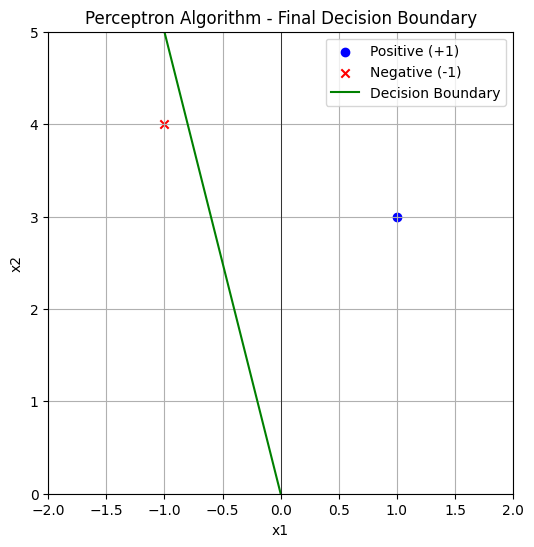

In [ ]:


# Data points and labels
data_points = np.array([[1, 3], [-1, 4]])
labels = np.array([1, -1])

# Initialize weight vector and bias
w = np.array([0.0, 0.0])  # Weight vector
b = 0

updates = []  # Store weight updates


converged = False
iteration = 0

while not converged:
    converged = True
    for i in range(len(data_points)):
        x = data_points[i]
        y = labels[i]


        if y * (np.dot(w, x) + b) <= 0:
            # Update weights and bias
            if y == 1:
              w += x
            else:
              w -= x
            updates.append(w.copy())  # Store the updated weight
            converged = False

    iteration += 1

# Plot the data
plt.figure(figsize=(6, 6))
plt.scatter(data_points[0, 0], data_points[0, 1], color='blue', marker='o', label="Positive (+1)")
plt.scatter(data_points[1, 0], data_points[1, 1], color='red', marker='x', label="Negative (-1)")

x_vals = np.linspace(-2, 2, 100)
if w[1] != 0:
    y_vals = -(w[0] / w[1]) * x_vals - b / w[1]
    plt.plot(x_vals, y_vals, color='green', label="Decision Boundary")

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlim(-2, 2)
plt.ylim(0, 5)
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Perceptron Algorithm - Final Decision Boundary")
plt.grid()

# Display weight updates and plot
import pandas as pd
df_updates = pd.DataFrame(updates, columns=["w1", "w2"])
df_updates
plt.show()


In [ ]:
df_updates

,w1,w2
0,1.0,3.0
1,2.0,-1.0
2,3.0,2.0
3,4.0,-2.0
4,5.0,1.0
